# Homework 5

## PreProcess

**The importation library**

In [33]:
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from queue import Queue
import numpy as np

**Reading documents**

Set the graph with networkx.

In [34]:
graph = nx.DiGraph()
# for each link in links add edge
# the weight of edges is 1 (for all)
for line in open('wikigraph_reduced.csv', 'r').readlines()[1:]:
    nodes = line.replace('\n', '').split('\t')
    graph.add_edge(int(nodes[1]), int(nodes[2]), weight=1)

Set the category dictionary.

In [35]:
categories = dict()
#for each category set the name as key and a list of nodes as article
for line in open('wiki-topcats-categories.txt', 'r').readlines():
    s = line.index(':')
    e = line.index(';')
    cat_name = line[s+1 : e].replace('_', ' ')
    cat_list = line[e+1:].split()
    categories[cat_name] = [int(c) for c in cat_list]

Compute the reverse index for categories: for each article a list of categories.

In [36]:
art_cat = defaultdict(list)
for name, values in categories.items():
    for value in values:
        art_cat[value].append(name)

Set with _art_cat_ dictionary a new dict with a single category for each page. The category is choice randomly.

In [37]:
page_category = { page : np.random.choice(values, 1)[0] for page, values in art_cat.items() }

Now re-convert the _categories_ dictionary with all pages for each category.

In [38]:
categories = defaultdict(list)
for page, category in page_category.items():
    categories[category].append(page)

Set a list of pages names: for each index of a list the corrispondent page name (article name).

In [39]:
page_names = list()
for line in open('wiki-topcats-page-names.txt', 'r').readlines():
    i = line.index(' ')
    page_names.append(line[i+1:].replace('\n', ''))

compute the inverted_page_names: a dict with names as keys and index as values.

In [40]:
inverted_page_names = dict()
for index, name in enumerate(page_names):
    inverted_page_names[name] = index

## RQ1

G is in the variable _graph_.

It is a directed network with all edges with weight equal to 1.

In [10]:
# Number of articles
print("The number of articles (nodes) are", len(graph.nodes))

The number of articles (nodes) are 98343


In [11]:
# number of edges/hyperlinks 
print("The number of hyperlinks (edges) are", len(graph.edges))

The number of hyperlinks (edges) are 483094


In [27]:
# count incoming links
incoming_links = dict(graph.degree)

# average number of degree: incoming links
print("The average number of incoming links in an arbitrary page is",\
      round(np.mean(list(incoming_links.values())), 2))
print("The minimum number of incoming links is", min(incoming_links.values()),\
     "and the maximum is", max(incoming_links.values()))

The average number of incoming links in an arbitrary page is 9.82
The minimum number of incoming links is 1 and the maximum is 10832


In [13]:
# count the outgoing links
outgoing_links = dict(graph.out_degree)

# print average
print("The average number of outgoing links in an arbitrary page is",\
      round(np.mean(list(outgoing_links.values())), 2))
print("The minimum number of outgoing links is", min(outgoing_links.values()),\
     "and the maximum is", max(outgoing_links.values()))

The average number of outgoing links in an arbitrary page is 4.91
The minimum number of outgoing links is 0 and the maximum is 1367


In [14]:
# density of graph
print("The density of graph is", round(len(graph.edges)/(len(graph.nodes)*(len(graph.nodes)-1)), 5))

The density of graph is 5e-05


To evaluate the density result we can match the our result with the result of built-in function of networkx.

In [15]:
print("Its value is", round(nx.density(graph), 5))

Its value is 5e-05


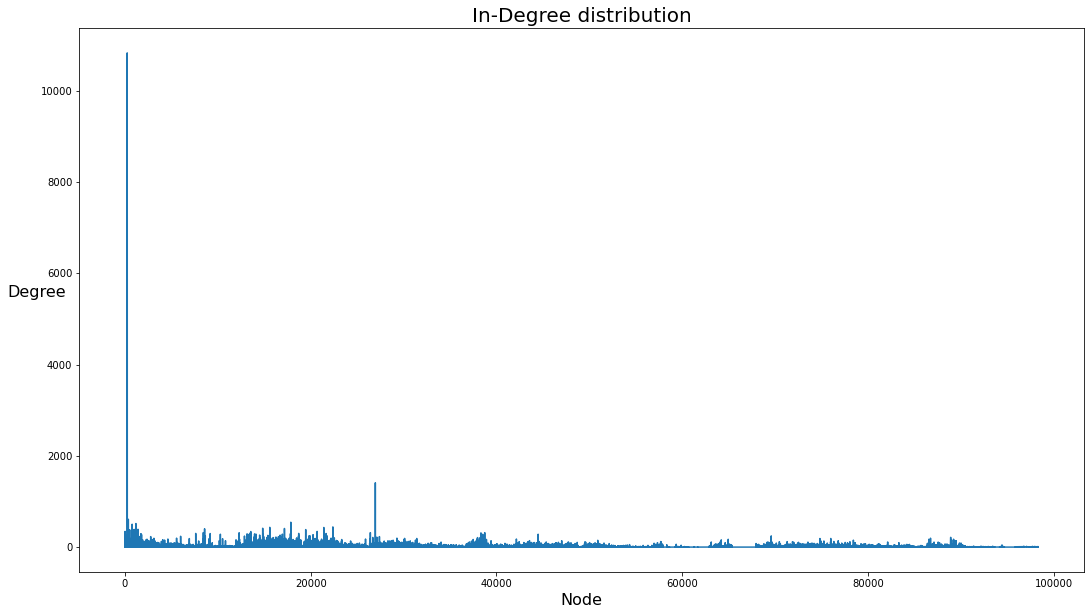

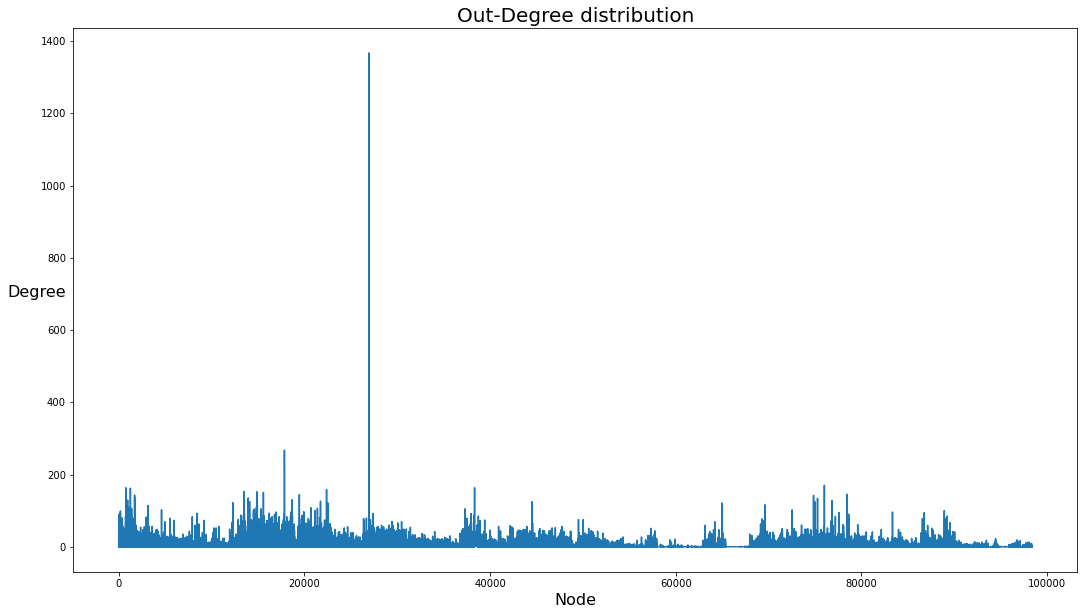

In [16]:
# degree distrubution
plt.figure(figsize=(18,10))
plt.title("In-Degree distribution", fontsize=20)
plt.xlabel('Node', fontsize=16)
plt.ylabel('Degree', fontsize=16, rotation=360)
plt.plot(list(incoming_links.values()))

plt.figure(figsize=(18,10))
plt.title("Out-Degree distribution", fontsize=20)
plt.xlabel('Node', fontsize=16)
plt.ylabel('Degree', fontsize=16, rotation=360)
plt.plot(list(outgoing_links.values()))

## RQ2

The function __exploring__ take in input a page _v_ and a number of clcks _d_ and return a set of pages that user can reach in _d_ clicks from _v_.

In [215]:
# function to explore graph
def exploring(v, d):
    p = inverted_page_names[v]
    indices = set()
    support_exploring(p, d, indices)
    return { page_names[i] for i in indices }

# support function for returning values
def support_exploring(v, d, ret):
    # v: page
    # d: number of clicks
    # g: input graph
    # r: return value
    if d == 0:
        return 
    for n in graph.neighbors(v):
        ret.add(n)
        support_exploring(n, d-1, ret)

In the next cell there is a sample of function execution with inputs:
- page: 'This Way (Hana Pestle album)';
- number of clicks: 3.

And after that another one with inputs:
- page: "Marty O'Brien";
- number of clicks: 1.

In [217]:
exploring('This Way (Hana Pestle album)', 2)

{'22nd Century Lifestyle',
 'A Rhyme & Reason',
 'Kelly Clarkson',
 'Lindsay Lohan',
 'Ma',
 'Marilyn Manson',
 "Marty O'Brien"}

In [19]:
exploring("Marty O'Brien", 1)

{'22nd Century Lifestyle',
 'A Rhyme & Reason',
 'Kelly Clarkson',
 'Lindsay Lohan',
 'Ma',
 'Marilyn Manson'}

# RQ-3

In [135]:
# Find the central page in a category

def central_article(c):
    # c: category
    v = None
    d = 0
    degree = dict(graph.degree)
    for node in categories[c]:
        try:
            if degree[node] >= d:
                v = node
                d = degree[node]
        except:
            pass
    return v

In [140]:
# find the shortest path between two pages

def shortest_path(v,t):
    # v is the source page
    # t is the target page
    the_list = []
    dist = 0
    the_list = list(graph.neighbors(v))
    if t in the_list:
        dist +=1
        return dist
    else:
        dist +=1 
        while t not in the_list:
            the_set = set()
            for node in the_list:
                x = list(graph.neighbors(node))
                for node in x:
                    the_set.add(node)
            the_list = list(the_set)
            dist +=1
        return dist

In [169]:
# define the set for all reachable pages from v.

big_set = set()
the_list = list(graph.neighbors(v))
for node in the_list:
    big_set.add(node)
    
for i in tqdm(range(25)):
    the_set = set()
    for node in the_list:
        x = list(graph.neighbors(node))
        for node in x:
            the_set.add(node)
            big_set.add(node)
    the_list = list(the_set)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.06it/s]


In [214]:
# define a category and find the most centered page

c = 'Main Belt asteroids'
v = central_article(c)

# we have add all pages from category c to make sure our algorithm returns correct result

p = []
for i in range(len(categories[c])):
    p.append(categories[c][i])

# now we can check whether a page is reachable from most centered page and find the shortest path for each page defined above.

column_names = ['Page_Name', 'Distance']
df = pd.DataFrame(columns = column_names)
the_names = []
the_dist = []

print ('We can reach to the pages written below with the steps written next to them:')

for node in p:
    if node not in big_set:
        step = str('Not Possible')
        the_names.append(page_names[node])
        the_dist.append(step)
        #print(page_names[node], 'Not possible!')
    else:
        step = Shortest_Path(v,node)
        the_names.append(page_names[node])
        the_dist.append(step)
df['Page_Name'] = the_names
df['Distance'] = the_dist
df = df.loc[pd.to_numeric(df.Distance, errors='coerce').sort_values().index]
df = df.reset_index(drop=True)
for i in range(len(df)):
    print(df['Page_Name'][i] + ' with ' + str(df['Distance'][i]) + ' step(s)')

We can reach to the pages written below with the steps written next to them:
132524 APL with 1 step(s)
5 Astraea with 1 step(s)
434 Hungaria with 1 step(s)
298 Baptistina with 1 step(s)
7472 Kumakiri with 1 step(s)
2867 teins with 1 step(s)
Phocaea family with 1 step(s)
1459 Magnya with 1 step(s)
4652 Iannini with 1 step(s)
Asteroid belt with 2 step(s)
Cybele asteroid with 2 step(s)
596 Scheila with 2 step(s)
45 Eugenia with 2 step(s)
64 Angelina with 2 step(s)
192 Nausikaa with 2 step(s)
Linus (moon) with 2 step(s)
Augusta family with 2 step(s)
566 Stereoskopia with 3 step(s)
18 Melpomene with 3 step(s)
Petit-Prince (moon) with 3 step(s)
784 Pickeringia with 4 step(s)
612 Veronika with 4 step(s)
5540 Smirnova with 5 step(s)
547 Praxedis with 5 step(s)
543 Charlotte with 5 step(s)
520 Franziska with 5 step(s)
545 Messalina with 5 step(s)
1418 Fayeta with 5 step(s)
564 Dudu with 5 step(s)
567 Eleutheria with 5 step(s)
548 Kressida with 5 step(s)
544 Jetta with 5 step(s)
571 Dulcinea wit

4003 Schumann with Not Possible step(s)
7583 Rosegger with Not Possible step(s)
90709 Wettin with Not Possible step(s)
15265 Ernsting with Not Possible step(s)
9052 Uhland with Not Possible step(s)
30933 Grillparzer with Not Possible step(s)
10740 Fallersleben with Not Possible step(s)
24751 Kroemer with Not Possible step(s)
5835 Mainfranken with Not Possible step(s)
13478 Fraunhofer with Not Possible step(s)
10763 Hlawka with Not Possible step(s)
11916 Wiesloch with Not Possible step(s)
9344 Klopstock with Not Possible step(s)
85215 Hohenzollern with Not Possible step(s)
46563 Oken with Not Possible step(s)
6396 Schleswig with Not Possible step(s)
6864 Starkenburg with Not Possible step(s)
7584 Ossietzky with Not Possible step(s)
48480 Falk with Not Possible step(s)
29203 Schnitger with Not Possible step(s)
20012 Ranke with Not Possible step(s)
30837 Steinheil with Not Possible step(s)
19182 Pitz with Not Possible step(s)
16524 Hausmann with Not Possible step(s)
7127 Stifter with Not 

363 Padua with Not Possible step(s)
301 Bavaria with Not Possible step(s)
274 Philagoria with Not Possible step(s)
51 Nemausa with Not Possible step(s)
441 Bathilde with Not Possible step(s)
335 Roberta with Not Possible step(s)
416 Vaticana with Not Possible step(s)
322 Phaeo with Not Possible step(s)
394 Arduina with Not Possible step(s)
246 Asporina with Not Possible step(s)
331 Etheridgea with Not Possible step(s)
279 Thule with Not Possible step(s)
417 Suevia with Not Possible step(s)
148 Gallia with Not Possible step(s)
161 Athor with Not Possible step(s)
404 Arsino with Not Possible step(s)
139 Juewa with Not Possible step(s)
276 Adelheid with Not Possible step(s)
140 Siwa with Not Possible step(s)
406 Erna with Not Possible step(s)
304 Olga with Not Possible step(s)
93 Minerva with Not Possible step(s)
269 Justitia with Not Possible step(s)
132 Aethra with Not Possible step(s)
115 Thyra with Not Possible step(s)
230 Athamantis with Not Possible step(s)
405 Thia with Not Possibl

6223 Dahl with Not Possible step(s)
12374 Rakhat with Not Possible step(s)
5995 Saint-Aignan with Not Possible step(s)
8371 Goven with Not Possible step(s)
20017 Alixcatherine with Not Possible step(s)
9930 Billburrows with Not Possible step(s)
9922 Catcheller with Not Possible step(s)
1221 Amor with Not Possible step(s)
2249 Yamamoto with Not Possible step(s)
3008 Nojiri with Not Possible step(s)
1719 Jens with Not Possible step(s)
5704 Schumacher with Not Possible step(s)
2465 Wilson with Not Possible step(s)
4002 Shinagawa with Not Possible step(s)
4979 Otawara with Not Possible step(s)
2022 West with Not Possible step(s)
1005 Arago with Not Possible step(s)
1669 Dagmar with Not Possible step(s)
1720 Niels with Not Possible step(s)
1123 Shapleya with Not Possible step(s)
1561 Fricke with Not Possible step(s)
1079 Mimosa with Not Possible step(s)
1815 Beethoven with Not Possible step(s)
2896 Preiss with Not Possible step(s)
1782 Schneller with Not Possible step(s)
1117 Reginita with 

8441 Lapponica with Not Possible step(s)
5342 Le Poole with Not Possible step(s)
7625 Louisspohr with Not Possible step(s)
2318 Lubarsky with Not Possible step(s)
7972 Mariotti with Not Possible step(s)
7971 Meckbach with Not Possible step(s)
6885 Nitardy with Not Possible step(s)
8602 Oedicnemus with Not Possible step(s)
8442 Ostralegus with Not Possible step(s)
5341 Purgathofer with Not Possible step(s)
8585 Purpurea with Not Possible step(s)
8590 Pygargus with Not Possible step(s)
4977 Rauthgundis with Not Possible step(s)
7689 Reinerstoss with Not Possible step(s)
7148 Reinholdbien with Not Possible step(s)
8592 Rubetra with Not Possible step(s)
8587 Ruficollis with Not Possible step(s)
8597 Sandvicensis with Not Possible step(s)
6352 Schlaun with Not Possible step(s)
4906 Seneferu with Not Possible step(s)
2042 Sitarski with Not Possible step(s)
6938 Soniaterk with Not Possible step(s)
6106 Stoss with Not Possible step(s)
8443 Svecica with Not Possible step(s)
6884 Takeshisato wit

1291 Phryne with Not Possible step(s)
1541 Estonia with Not Possible step(s)
5040 Rabinowitz with Not Possible step(s)
13474 V'yus with Not Possible step(s)
6697 Celentano with Not Possible step(s)
4664 Hanner with Not Possible step(s)
8474 Rettig with Not Possible step(s)
6371 Heinlein with Not Possible step(s)
6204 MacKenzie with Not Possible step(s)
2672 Psek with Not Possible step(s)
2081 Szava with Not Possible step(s)
3081 Martinboh with Not Possible step(s)
1861 Komensk with Not Possible step(s)
4283 Stffler with Not Possible step(s)
3827 Zdenkhorsk with Not Possible step(s)
1407 Lindelf with Not Possible step(s)
5897 Novotn with Not Possible step(s)
5910 Ztopek with Not Possible step(s)
6795 rnskldsvik with Not Possible step(s)
7695 Pemysl with Not Possible step(s)
5951 Alicemonet with Not Possible step(s)
4339 Almamater with Not Possible step(s)
6947 Andrewdavis with Not Possible step(s)
8257 Andycheng with Not Possible step(s)
1395 Aribeda with Not Possible step(s)
4696 Arpig

6243 Yoder with Not Possible step(s)
7936 Mikemagee with Not Possible step(s)
6312 Robheinlein with Not Possible step(s)
12321 Zurakowski with Not Possible step(s)
14354 Kolesnikov with Not Possible step(s)
1677 Tycho Brahe with Not Possible step(s)
6460 Bassano with Not Possible step(s)
22370 Italocalvino with Not Possible step(s)
11241 Eckhout with Not Possible step(s)
11242 Franspost with Not Possible step(s)
8266 Bertelli with Not Possible step(s)
1203 Nanna with Not Possible step(s)
6550 Parl with Not Possible step(s)
10189 Normanrockwell with Not Possible step(s)
7462 Grenoble with Not Possible step(s)
24048 Pedroduque with Not Possible step(s)
37391 Ebre with Not Possible step(s)
19539 Anaverdu with Not Possible step(s)
25472 Joanoro with Not Possible step(s)
29555 MACEK with Not Possible step(s)
29646 Polya with Not Possible step(s)
29736 Fichtelberg with Not Possible step(s)
29189 Udinsk with Not Possible step(s)
29187 Lemonnier with Not Possible step(s)
29391 Knight with Not 

21729 Kimrichards with Not Possible step(s)
16128 Kirfrieda with Not Possible step(s)
17993 Kluesing with Not Possible step(s)
21642 Kominers with Not Possible step(s)
17002 Kouzel with Not Possible step(s)
17794 Kowalinski with Not Possible step(s)
13824 Kramlik with Not Possible step(s)
19430 Kristinaufer with Not Possible step(s)
18004 Krystosek with Not Possible step(s)
17815 Kulawik with Not Possible step(s)
18780 Kuncham with Not Possible step(s)
19595 Lafer-Sousa with Not Possible step(s)
21672 Laichunju with Not Possible step(s)
18857 Lalchandani with Not Possible step(s)
18043 Laszkowska with Not Possible step(s)
18774 Lavanture with Not Possible step(s)
21915 Lavins with Not Possible step(s)
18826 Leifer with Not Possible step(s)
17900 Leiferman with Not Possible step(s)
15088 Licitra with Not Possible step(s)
17889 Liechty with Not Possible step(s)
19542 Lindperkins with Not Possible step(s)
21628 Lucashof with Not Possible step(s)
19417 Madelynho with Not Possible step(s)
1

18932 Robinhood with Not Possible step(s)
18132 Spector with Not Possible step(s)
17269 Dicksmith with Not Possible step(s)
15092 Beegees with Not Possible step(s)
24450 Victorchang with Not Possible step(s)
21476 Petrie with Not Possible step(s)
11196 Michanikos with Not Possible step(s)
9241 Rosfranklin with Not Possible step(s)
19578 Kirkdouglas with Not Possible step(s)
18747 Lexcen with Not Possible step(s)
17892 Morecambewise with Not Possible step(s)
19453 Murdochorne with Not Possible step(s)
20468 Petercook with Not Possible step(s)
41488 Sindbad with Not Possible step(s)
44217 Whittle with Not Possible step(s)
43293 Banting with Not Possible step(s)
23774 Herbelliott with Not Possible step(s)
20314 Johnharrison with Not Possible step(s)
13298 Namatjira with Not Possible step(s)
17826 Normanwisdom with Not Possible step(s)
19535 Rowanatkinson with Not Possible step(s)
17166 Secombe with Not Possible step(s)
8958 Stargazer with Not Possible step(s)
16155 Buddy with Not Possible

6219 Demalia with Not Possible step(s)
5087 Emel'yanov with Not Possible step(s)
6576 Kievtech with Not Possible step(s)
7106 Kondakov with Not Possible step(s)
4883 Korolirina with Not Possible step(s)
4655 Marjoriika with Not Possible step(s)
4392 Agita with Not Possible step(s)
5889 Mickiewicz with Not Possible step(s)
4657 Lopez with Not Possible step(s)
11790 Goode with Not Possible step(s)
7980 Senkevich with Not Possible step(s)
5543 Sharaf with Not Possible step(s)
5614 Yakovlev with Not Possible step(s)
4920 Gromov with Not Possible step(s)
5455 Surkov with Not Possible step(s)
2810 Lev Tolstoj with Not Possible step(s)
2724 Orlov with Not Possible step(s)
2787 Tovarishch with Not Possible step(s)
2610 Tuva with Not Possible step(s)
2836 Sobolev with Not Possible step(s)
3660 Lazarev with Not Possible step(s)
3373 Koktebelia with Not Possible step(s)
4308 Magarach with Not Possible step(s)
4141 Nintanlena with Not Possible step(s)
4187 Shulnazaria with Not Possible step(s)
237

12932 Conedera with Not Possible step(s)
5032 Conradhirsh with Not Possible step(s)
9758 Dainty with Not Possible step(s)
6941 Dalgarno with Not Possible step(s)
15960 Hlubok with Not Possible step(s)
15950 Dallago with Not Possible step(s)
24236 Danielberger with Not Possible step(s)
29562 Danmacdonald with Not Possible step(s)
13168 Danoconnell with Not Possible step(s)
10720 Danzl with Not Possible step(s)
15887 Daveclark with Not Possible step(s)
24153 Davidalex with Not Possible step(s)
19969 Davidfreedman with Not Possible step(s)
15911 Davidgauthier with Not Possible step(s)
24278 Davidgreen with Not Possible step(s)
13329 Davidhardy with Not Possible step(s)
84921 Morkolb with Not Possible step(s)
23751 Davidprice with Not Possible step(s)
1037 Davidweilla with Not Possible step(s)
11243 de Graauw with Not Possible step(s)
5522 De Rop with Not Possible step(s)
13395 Deconihout with Not Possible step(s)
8897 Defelice with Not Possible step(s)
15631 Dellorusso with Not Possible s

6890 Savinykh with Not Possible step(s)
24728 Scagell with Not Possible step(s)
8887 Scheeres with Not Possible step(s)
7881 Schieferdecker with Not Possible step(s)
24060 Schimenti with Not Possible step(s)
6295 Schmoll with Not Possible step(s)
13724 Schwehm with Not Possible step(s)
17898 Scottsheppard with Not Possible step(s)
17216 Scottstuart with Not Possible step(s)
78905 Seanokeefe with Not Possible step(s)
6553 Seehaus with Not Possible step(s)
8310 Seelos with Not Possible step(s)
18567 Segenthau with Not Possible step(s)
7285 Seggewiss with Not Possible step(s)
21985 ejna with Not Possible step(s)
97268 Serafinozani with Not Possible step(s)
14975 Serasin with Not Possible step(s)
24155 Serganov with Not Possible step(s)
4470 Sergeev-Censkij with Not Possible step(s)
7730 Sergerasimov with Not Possible step(s)
23755 Sergiolozano with Not Possible step(s)
6818 Sessyu with Not Possible step(s)
24607 Sevnatu with Not Possible step(s)
66671 Sfasu with Not Possible step(s)
13921

22497 Immanuelfuchs with Not Possible step(s)
30418 Jakobsteiner with Not Possible step(s)
29447 Jerzyneyman with Not Possible step(s)
31931 Sipiera with Not Possible step(s)
20135 Juels with Not Possible step(s)
21331 Lodovicoferrari with Not Possible step(s)
30307 Marcelriesz with Not Possible step(s)
7684 Marioferrero with Not Possible step(s)
10598 Markrees with Not Possible step(s)
27915 Nancywright with Not Possible step(s)
23699 Paulgordan with Not Possible step(s)
16810 Pavelaleksandrov with Not Possible step(s)
19462 Ulissedini with Not Possible step(s)
20155 Utewindolf with Not Possible step(s)
21276 Feller with Not Possible step(s)
12007 Fermat with Not Possible step(s)
12016 Green with Not Possible step(s)
12874 Poisson with Not Possible step(s)
12513 Niven with Not Possible step(s)
30443 Stieltjes with Not Possible step(s)
30305 Severi with Not Possible step(s)
13642 Ricci with Not Possible step(s)
17637 Blaschke with Not Possible step(s)
17653 Bochner with Not Possible st

## RQ4

The function __double_cat_subg__ returns a subgraph with the nodes and the edges corrispondent with the nodes present in the two categories.

The function __my_double_cat_subg__ has an implementation from scratch of the function subgraph of networkx library.

The result of the two function is the same.

In [25]:
def double_cat_subg(c1, c2):
    # c1: category 1
    # c2: category 2
    cat_nodes = set(categories[c1]) | set(categories[c2]) # the set of all possible nodes
    cat_nodes = cat_nodes & set(graph.nodes) # clean the node
    return graph.subgraph(cat_nodes)

In [26]:
def my_double_cat_subg(c1, c2):
    # c1: category 1
    # c2: category 2
    cat_nodes = set(categories[c1]) | set(categories[c2]) # the set of all possible nodes
    cat_nodes = cat_nodes & set(graph.nodes) # clean the node
    sg = nx.DiGraph()
    sg.add_nodes_from((n, graph.nodes[n]) for n in cat_nodes)
    sg.add_edges_from((n, nbr, d) for n, nbrs in graph.adj.items() if n in cat_nodes\
                      for nbr, d in nbrs.items() if nbr in cat_nodes)
    return sg

The function below find the best path between two nodes _u_ and _v_.

In [27]:
# finds shortest path between 2 nodes of a graph using BFS
def bfs_shortest_path(u, v, g):
    # u: start node
    # v: goal node
    # g: graph
    
    # keep track of explored nodes
    explored = []
    # keep track of all the paths to be checked
    queue = [[u]]
 
    # return path if start is goal
    if u == v:
        return "Exception: u and v are the same node" # no path! the nodes are the same
 
    # keeps looping until all possible paths have been checked
    while queue:
        # pop the first path from the queue
        path = queue.pop(0)
        # get the last node from the path
        node = path[-1]
        if node not in explored:
            # go through all neighbour nodes, construct a new path and
            # push it into the queue
            for neighbour in g.neighbors(node):
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)
                # return path if neighbour is goal
                if neighbour == v:
                    return new_path
 
            # mark node as explored
            explored.append(node)
 
    # in case there's no path between the 2 nodes
    return "Not possible"

In the cell below there is an example of the previous two functions.

In [28]:
sg = my_double_cat_subg('Main Belt asteroids', 'People from Worcester')
print("The subgraph is composed by 'Main Belt asteroids' and 'People from Worcester' categories.")
print( "That is an example of shortest path returned with 96584 870882 such nodes -->", bfs_shortest_path(96584, 870882, sg))

The subgraph is composed by 'Main Belt asteroids' and 'People from Worcester' categories.


NetworkXError: The node 96584 is not in the digraph.

The function below find the lenght of the minimum set of hyperlinks one can remove to disconnect _u_ and _v_.

In [29]:
def min_cut_subg(c1, c2, u, v):
    # c1: category 1
    # c2: category 2
    # u: start node
    # v: goal node
    sg = my_double_cat_subg(c1, c2)
    count = 0
    loop = True
    n1 = inverted_page_names[u]
    n2 = inverted_page_names[v]
    while loop:
        path = bfs_shortest_path(n1, n2, sg)
        if type(path) is str:
            loop = False
        else:
            count += 1
            removing = [ (path[i-1], path[i] ) for i in range(1, len(path)) ]
            for edge in removing:
                sg.remove_edge(*edge)
    return count

An example of function excution on the categories and the nodes of the previous example.

In [30]:
c1 = 'Main Belt asteroids'
c2 = 'People from Worcester'
u = page_names[96584]
v = page_names[870882]

print("The lenght of minimum set of hyperlinks one can remove to disconnect u and v is", min_cut_subg(c1, c2, u, v))

NetworkXError: The node 96584 is not in the digraph.

In the next two cells there are two support function for the __min_cut_subg_set__.
It finds he minimum set of hyperlinks one can remove to disconnect the nodes _u_ and _v_.

In [31]:
def sublists(l):
    # l: input list
    
    # list to store all the sublists 
    sublist = [] 
    for i in range(len(l) + 1): 
        for j in range(i + 1, len(l) + 1): 
            sli = l[i:j]  # make a slice of the subarray 
            sublist.append(sli) #add it to the list of sublists
    # sort list in order with the len of sublist
    sublist.sort(key=len)
    return sublist 

In [32]:
def connected(u, v, g):
    # u: start node
    # v: goal node
    # g: graph
    
    # keep track of explored nodes
    explored = []
    # keep track of all the nodes to be checked
    queue = [u] 
    if u == v:
        return None # no connection! the nodes are the same
    # keeps looping until all possible paths have been checked
    while queue:
        node = queue.pop(0)
        if node not in explored:
            for neighbour in g.neighbors(node):
                queue.append(neighbour)
                # return path if neighbour is goal
                if neighbour == v:
                    return True # there is a path!
            # mark node as explored
            explored.append(node)
    # in case there's no path between the 2 nodes
    return False

In [33]:
def min_cut_subg_set(c1, c2, u, v):
    # c1: category 1
    # c2: category 2
    # u: start node
    # v: goal node
    
    sg = my_double_cat_subg(c1, c2) # set subgraph
    loop = True
    n1 = inverted_page_names[u]
    n2 = inverted_page_names[v]
    
    removed = [] # the lit of edges removed
    while loop:
        path = bfs_shortest_path(n1, n2, sg)
        if type(path) is not str:
            r = [ (path[i-1], path[i] ) for i in range(1, len(path)) ]
            removing = sublists(r)
            # check wich set of edges doing disconnection
            for edgelist in removing:
                g = nx.Graph(sg)
                for edge in edgelist:
                    g.remove_edge(*edge)
                if not connected(n1, n2, g):
                    removed += edgelist
                    # return the correct set of edges
                    return { (page_names[edge[0]], page_names[edge[1]]) for edge in set(removed) }
            # repeat loop with new graph    
            for edge in r:
                sg.remove_edge(*edge)
            removed += r
        else:
            loop = False
    return { (page_names[edge[0]], page_names[edge[1]]) for edge in set(removed) }

An example of execution.

In [34]:
c1 = 'Main Belt asteroids'
c2 = 'People from Worcester'
u = page_names[96584]
v = page_names[870882]

print("Below there is the set of hyperlinks could be removed to disconnect u and v.")
print(min_cut_subg_set(c1, c2, u, v))

Below there is the set of hyperlinks could be removed to disconnect u and v.


NetworkXError: The node 96584 is not in the digraph.

## RQ5

For this question we assume that *the set of shortest paths* is a set composed by the lengher of shortest path from each pair of nodes in the two categories.

In [60]:
# support function for search median in an ordered list
median = lambda l : int((l[len(l)//2] + l[~(len(l)//2)]) / 2)

# find shortestpath between two categories
def shortestpath(c1, c2):
    # c1: category 1
    # c2: category 2
    
    r = set()
    for n1 in categories[c1]:
        for n2 in categories[c2]:
            if n1 in graph.nodes and n2 in graph.nodes:
                path = bfs_shortest_path(n1, n2, graph)
                if type(path) is not str:
                    r.add(len(path))
    return r

In [80]:
def other_categories(c):
    # c: category
    
    all_cat = set(categories)
    all_cat.remove(c)
    all_cat = list(all_cat)
    # calculate shortestpath
    distances = list()
    for cat in tqdm(all_cat):
        sp = shortestpath(c, cat)
        print(cat)
        if len(sp) > 0:
            distances.append(median(sorted(list(sp))))
    all_cat = [x for _, x in sorted(zip(distances, all_cat))]
    return all_cat

In [ ]:
other_categories('Old Stoics')

  0%|          | 0/17358 [00:00<?, ?it/s]

Gauteng cricketers
African American members of the United States House of Representatives
International film festivals
Balao class submarines
Austrian Jews
The CW Television Network affiliates


MemoryError: Unable to allocate 72.1 GiB for an array with shape (98343, 98343) and data type float64

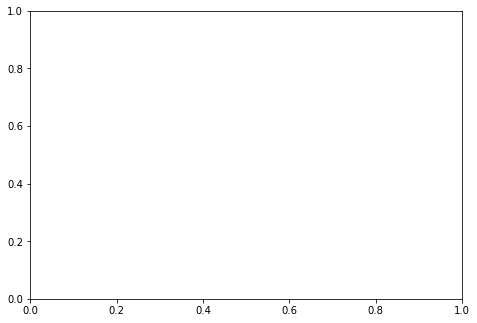

In [30]:
nx.draw(graph)